# Hydrodome Simulation Plotting Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from scipy.ndimage import gaussian_filter

## theoretical angular distributions

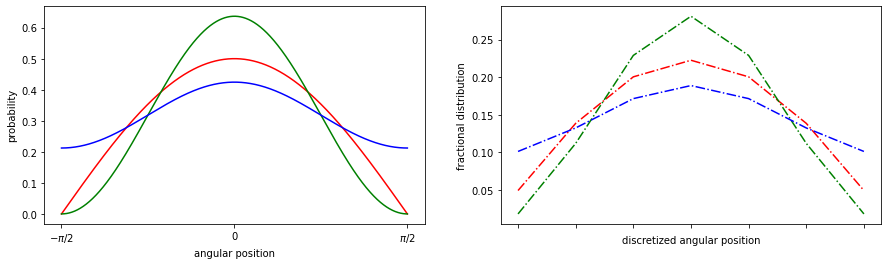

In [2]:
_N_per_edge = 1000
_N_edges = 7

theta = np.linspace(0,np.pi,_N_per_edge*_N_edges)
ballistic = np.sin(theta)/2.
noSlip = np.sin(theta)**2*2./np.pi
noStress = (1+np.sin(theta)**2)/np.pi*2/3

ballisticDist = np.zeros(_N_edges)
noSlipDist = np.zeros(_N_edges)
noStressDist = np.zeros(_N_edges)

for i in range(_N_edges):
    ballisticDist[i] = (np.sum(ballistic[i*_N_per_edge:((i+1)*_N_per_edge)]) /
                        (_N_per_edge*_N_edges)*np.pi)
    noSlipDist[i] = (np.sum(noSlip[i*_N_per_edge:((i+1)*_N_per_edge)]) /
                        (_N_per_edge*_N_edges)*np.pi)
    noStressDist[i] = (np.sum(noStress[i*_N_per_edge:((i+1)*_N_per_edge)]) /
                        (_N_per_edge*_N_edges)*np.pi)

fig = plt.figure(figsize=(15,4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

ax0.plot(theta*180/np.pi-90,ballistic,'r')
ax0.plot(theta*180/np.pi-90,noSlip,'g')
ax0.plot(theta*180/np.pi-90,noStress,'b')
ax0.set_xticks([-90,0,90])
ax0.set_xticklabels([r'$-\pi/2$',0,r'$\pi/2$'])
ax0.set_xlabel('angular position')
ax0.set_ylabel('probability')

ax1.plot(ballisticDist,'r-.')
ax1.plot(noSlipDist,'g-.')
ax1.plot(noStressDist,'b-.')
ax1.set_xticklabels([])
ax1.set_xlabel('discretized angular position')
ax1.set_ylabel('fractional distribution')
plt.show()

## plot simulation results

filename Base: Dome_T4_Probe0,4.25
total timesteps: 932
net particle flow: 120


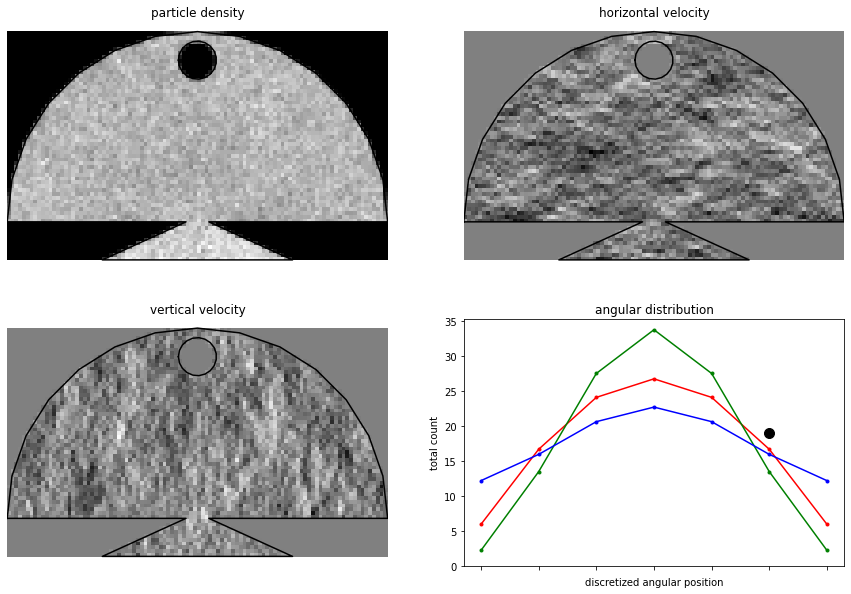

In [5]:
fnameBases = ['Dome_T4_Probe0,4.25'] #list of base name of simulations
Nsims = 1 #number of simulations
blur = 0 #performs a gaussian blur

symm = False #symmetrizes the output

N_bins = 7

angleDeps = np.zeros(((7,60)))
for fnameNum,fnameBase in enumerate(fnameBases):
    print('filename Base: '+fnameBase)
    
    fig = plt.figure(figsize = (15,10))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)

    #calculate the angle dependence and sum up the densities
    for i in range(Nsims):
        fname = fnameBase
        with np.load('./'+fname+'/'+fname+'_%03d.npz'%i) as mat:
            if i == 0:
                rho = mat['Erho'].copy()
                vX = mat['Px'].copy()
                vY = mat['Py'].copy()
                angleDep = ((mat['Nabsorbed'][0:(2*N_bins):2]+mat['Nabsorbed'][1:(2*N_bins):2])-
                            (mat['Ninjected'][0:(2*N_bins):2]+mat['Ninjected'][1:(2*N_bins):2]))
                print('total timesteps: %d'%mat['timeCount'])
                #load in the 2D histogram axes from simulation            
                histX = mat['histX']
                histY = mat['histY']
                borderX = mat['borderX']
                borderY = mat['borderY']
                edgeStyle = mat['edgeStyle']
                f = -2
            else:
                rho += mat['Erho']
                vX  += mat['Px']
                vY  += mat['Py']
                angleDep +=  ((mat['Nabsorbed'][0:(2*N_bins):2]+mat['Nabsorbed'][1:(2*N_bins):2])- 
                          (mat['Ninjected'][0:(2*N_bins):2]+mat['Ninjected'][1:(2*N_bins):2]))
     # inserts NaN for fictisious edges, so that they are not plotted
    for edge_idx in np.arange(len(edgeStyle)):
        idx_dif = len(borderX)-len(edgeStyle)  # difference between '' which changes with additions of NaNs
        edge = edgeStyle[edge_idx]
        if edge == f:
            borderX = np.insert(borderX,edge_idx + idx_dif, np.NaN)
            borderY = np.insert(borderY,edge_idx + idx_dif, np.NaN)
                

    #ax0 plots the particle density
    rhoPlot = gaussian_filter(rho.T,blur)
    m1 = np.median(rho)
    if symm:
        rhoPlot+=rhoPlot[:,::-1]
        rhoPlot/=2.
    ax0.pcolormesh(histX,histY,rhoPlot,cmap = 'gray')#, vmin = 0.99*m1,vmax = 1.02*m1)
    ax0.axis('off')
    ax0.plot(borderX,borderY,'k')
    ax0.axis('equal')
    
    #ax1 plots the horizontal velocity distribution
    vXplot = gaussian_filter(vX.T,blur)
    m1 = np.max(np.abs(vXplot))
    if symm:
        vXplot-=vXplot[:,::-1]
        vXplot/=2.
    ax1.pcolormesh(histX,histY,vXplot,cmap='gray', vmin=-m1, vmax=m1)
    ax1.axis('off')
    ax1.plot(borderX,borderY,'k')
    ax1.axis('equal')
    
    #ax2 plots the vertical velocity distribution
    vYplot = gaussian_filter(vY.T,blur)
    m1 = np.max(np.abs(vXplot))
    if symm:
        vYplot+=vYplot[:,::-1]
        vYplot/=2.
    ax2.pcolormesh(histX,histY,vYplot,cmap='gray', vmin=-m1, vmax=m1)
    ax2.axis('off')
    ax2.plot(borderX,borderY,'k')
    ax2.axis('equal')
    
    #ax3 plots the angular distribution
    if symm:
        angleDep+=angleDep[::-1]
        angleDep/=2.
    print('net particle flow: %d'%sum(angleDep))
    ax3.plot(ballisticDist*sum(angleDep),'r')
    ax3.plot(ballisticDist*sum(angleDep),'r.')
    ax3.plot(noSlipDist*sum(angleDep),'g')
    ax3.plot(noSlipDist*sum(angleDep),'g.')
    ax3.plot(noStressDist*sum(angleDep),'b')
    ax3.plot(noStressDist*sum(angleDep),'b.')
    ax3.set_ylim(np.array(plt.ylim())*np.array((0,1)));
    ax3.plot(angleDep,'k.',markerSize = 20)
    ax3.set_xlabel('discretized angular position')
    ax3.set_ylabel('total count')
    ax3.set_xticklabels([])
    
    ax0.set_title('particle density')
    ax1.set_title('horizontal velocity')
    ax2.set_title('vertical velocity')
    ax3.set_title('angular distribution')
    
    plt.show()

In [65]:
cross_section = vXplot[:, 70]

ValueError: x and y must have same first dimension, but have shapes (1,) and (60,)

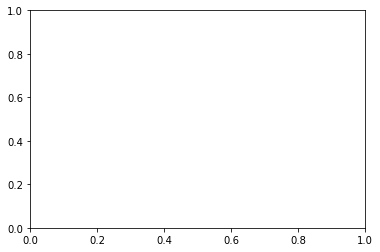

In [69]:
plt.plot(np.transpose(histX[70]), cross_section)

In [16]:

''.join(['h'])

'h'